In [1]:
import os, time
import numpy as np 
import corner as DFM
from astropy.io import fits
# --- gqp_mc ---
from gqp_mc import data as Data 
# --- provabgs --- 
from provabgs import infer as Infer
from provabgs import flux_calib as FluxCalib

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# lets read in some BGS-like photometry and spectra

In [3]:
specs, prop = Data.Spectra(sim='lgal', noise='bgs0', lib='bc03', sample='mini_mocha') 
photo, _ = Data.Photometry(sim='lgal', noise='legacy', sample='mini_mocha') 

In [4]:
prop.keys()

dict_keys(['galid', 't_lookback', 'dt', 'sfh_disk', 'sfh_bulge', 'Z_disk', 'Z_bulge', 'logM_disk', 'logM_bulge', 'logM_total', 't_age_MW', 'Z_MW', 'redshift', 'cosi', 'tau_ism', 'tau_bc', 'vd_disk', 'vd_bulge', 'logM_fiber', 'airmass', 'moon_alt', 'moon_ill', 'moon_sep', 'seeing', 'sun_alt', 'sun_sep', 'texp_total', 'transp', 'wave_sky', 'sbright_sky', 'sfr_1gyr', 'sfr_100myr'])

In [5]:
igal = 2
z = prop['redshift'][igal]
mstar = prop['logM_total'][igal]

(-1.0, 5.0)

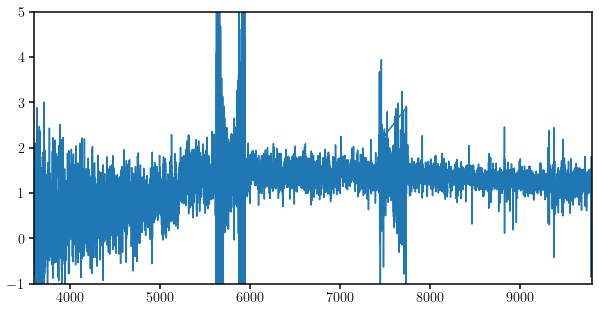

In [6]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(specs['wave'], specs['flux'][igal])
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylim(-1., 5.)

# set up the model, flux_calib, and prior

In [7]:
priors = Infer.load_priors([
        Infer.UniformPrior(8, 12, label='sed'),     # uniform priors on logM*
        Infer.FlatDirichletPrior(4, label='sed'),   # flat dirichilet priors
        Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
        Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
        Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust1 
        Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust2
        Infer.UniformPrior(-2.2, 0.4, label='sed')      # uniform priors on dust_index 
        ])

In [8]:
desi_mcmc = Infer.desiMCMC(prior=priors, flux_calib=FluxCalib.no_flux_factor)

In [9]:
t0 = time.time()
zeus_chain = desi_mcmc.run(
    wave_obs=specs['wave'], 
    flux_obs=specs['flux'][igal], 
    flux_ivar_obs=specs['ivar'][igal],
    zred=z, 
    sampler='zeus',
    nwalkers=30, 
    burnin=100,
    opt_maxiter=2000,
    niter=100, 
    debug=True)
print('%f sec' % (time.time() - t0))

--- initializing the walkers ---


Initialising ensemble of 30 walkers...
Sampling progress :   0%|          | 0/100 [00:00<?, ?it/s]

initial theta = [10.264849532751981, 0.9697790607832628, 0.36373762142180965, 0.3554821156505906, 0.011876902406182391, 0.0036146805684840154, 0.003946685417314441, 1.3403926155094235, 0.41618422873519356, -0.9923631306672789]
--- burn-in ---


Sampling progress : 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]
Initialising ensemble of 30 walkers...
Sampling progress :   0%|          | 0/100 [00:00<?, ?it/s]

--- running main MCMC ---


Sampling progress : 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]

Speculator.sed: redshift = 0.309752
Speculator.sed: tage = 10.179947
Speculator.sed: theta [ 1.02939408e+01  9.32818496e-01  2.71120785e-02  3.25297718e-02
  7.53965375e-03  4.00030789e-03  2.85073713e-03  1.58891566e+00
  3.89507491e-01 -7.73731428e-01  1.01799468e+01]
Speculator.sed: log(ssp lum) [-11.00126037 -11.00451221 -11.09864983 ...  -9.59718235  -9.60774732
  -9.61106987]
83.594395 sec


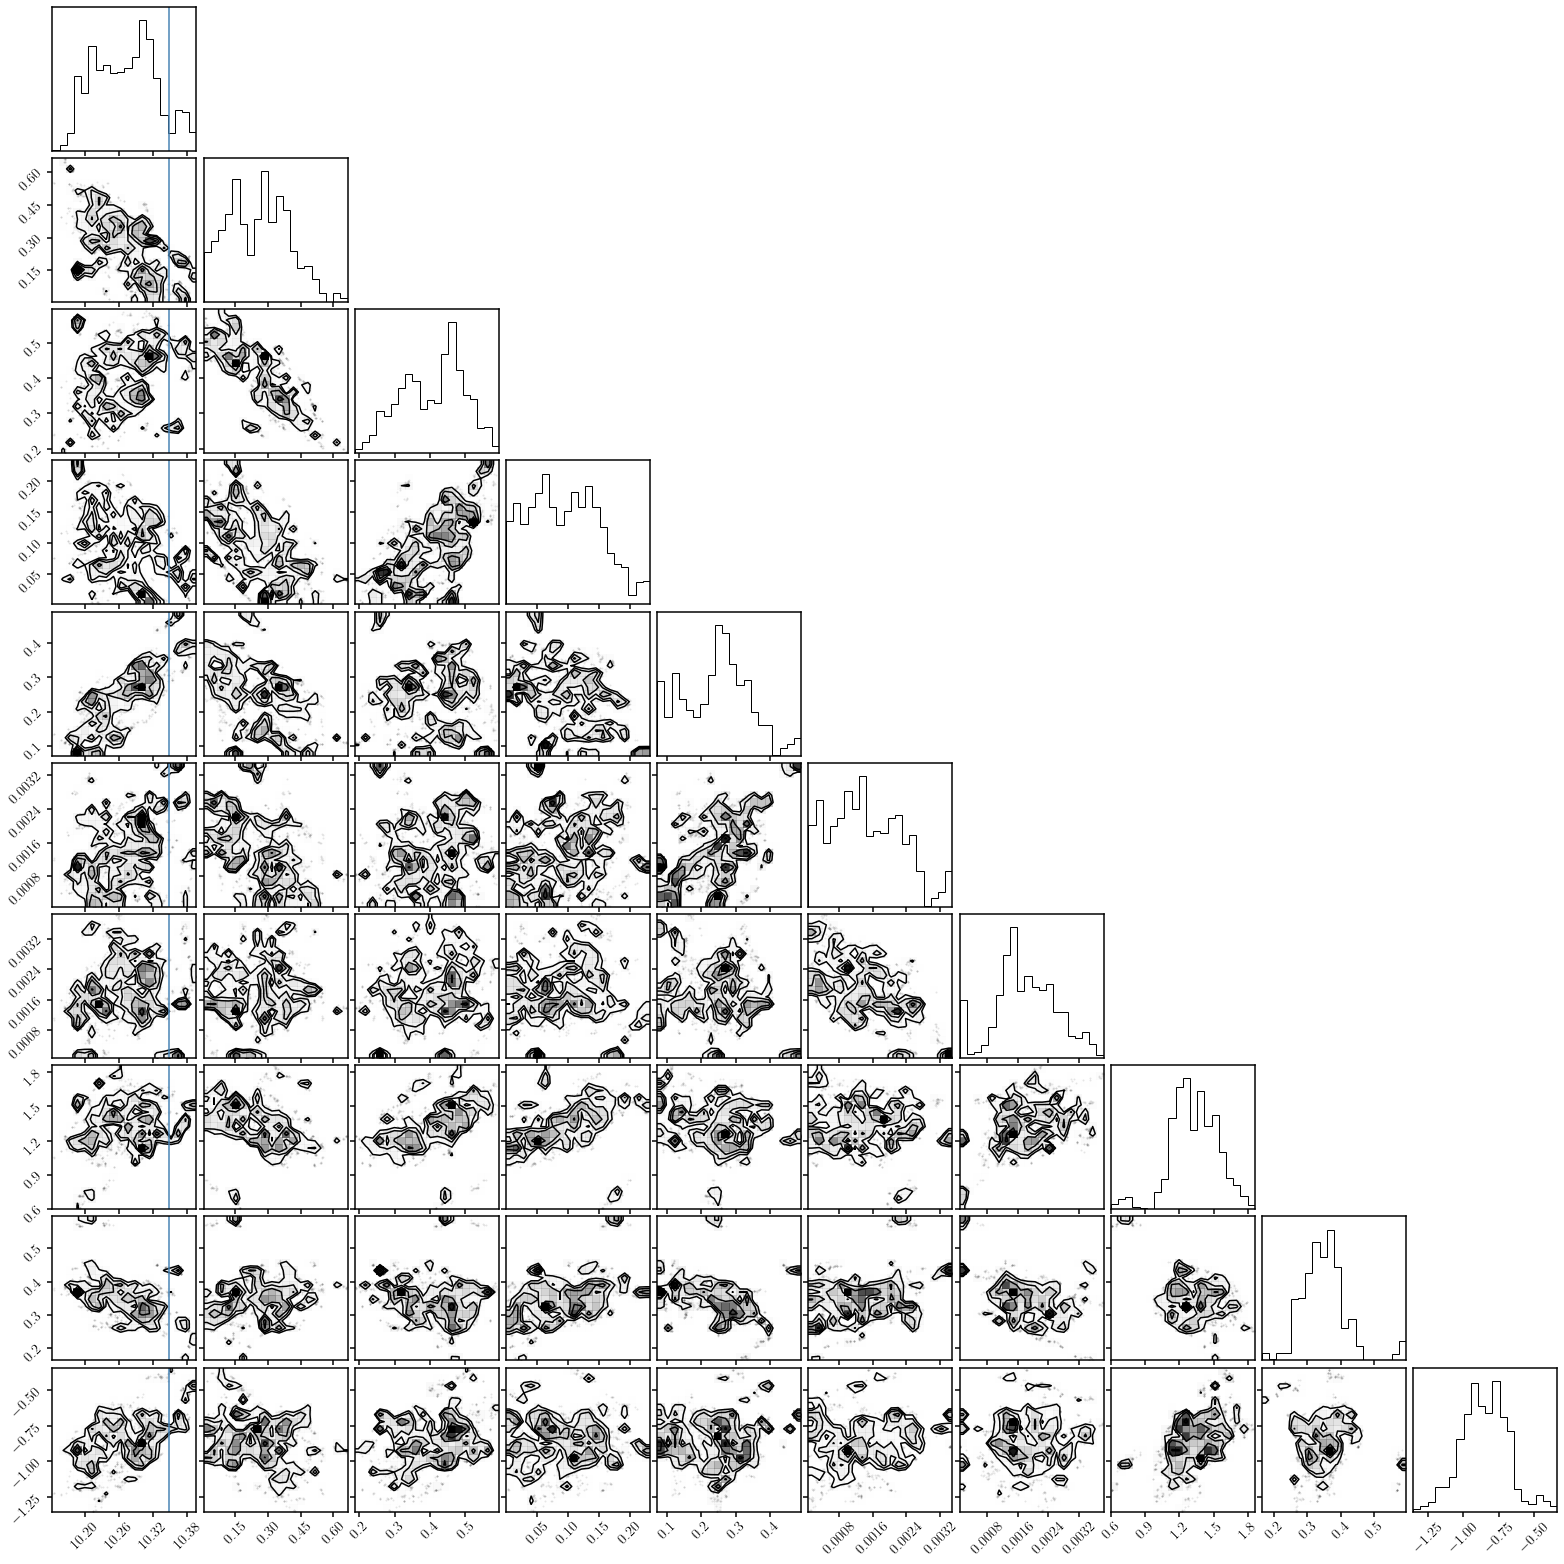

In [10]:
flat_chain = desi_mcmc._flatten_chain(zeus_chain['mcmc_chain'])
_ = DFM.corner(flat_chain, truths=[prop['logM_fiber'][igal], None, None, None, None, None, None, None, None, None, None])

# Now lets try out different MCMC set ups

In [11]:
priors = Infer.load_priors([
        Infer.UniformPrior(8, 12, label='sed'),
        Infer.FlatDirichletPrior(4, label='sed'), 
        Infer.UniformPrior(np.array([6.9e-5, 6.9e-5, 0., 0., -2.2]), np.array([7.3e-3, 7.3e-3, 3., 4., 0.4]), label='sed')     
])

In [12]:
desi_mcmc = Infer.desiMCMC(prior=priors, flux_calib=FluxCalib.no_flux_factor)

In [13]:
t0 = time.time()
zeus_chain = desi_mcmc.run(
    photo_obs=photo['flux'][igal,:3], 
    photo_ivar_obs=photo['ivar'][igal,:3],
    zred=z, 
    bands='desi',
    sampler='zeus',
    nwalkers=30, 
    burnin=100,
    opt_maxiter=2000,
    niter=100, 
    debug=True)
print('%f sec' % (time.time() - t0))

--- initializing the walkers ---


/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]
/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1520: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  integrand = integrand[values_slice]
Initialising ensemble of 30 walkers...
Sampling progress :   0%|          | 0/100 [00:00<?, ?it/s]

initial theta = [10.73529292150782, 0.7514990651361328, 2.114018309039241e-07, 0.43176477748558695, 0.9317533606457038, 0.006229418171138141, 0.0020358182079604063, 2.5040636937531273, 1.1678982132194845e-07, -1.4040175973062967]
--- burn-in ---


Sampling progress : 100%|██████████| 100/100 [01:07<00:00,  1.49it/s]
Initialising ensemble of 30 walkers...
Sampling progress :   0%|          | 0/100 [00:00<?, ?it/s]

--- running main MCMC ---


Sampling progress : 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]

Speculator.sed: redshift = 0.309752
Speculator.sed: tage = 10.179947
Speculator.sed: theta [ 1.07762177e+01  7.33798393e-01  9.81460824e-02  1.65883433e-01
  2.17209166e-03  6.56900415e-03  2.95284322e-03  1.49676626e+00
  2.55995421e-01 -3.87311843e-01  1.01799468e+01]
Speculator.sed: log(ssp lum) [-9.59795137 -9.61254889 -9.69727205 ... -9.49285971 -9.50513229
 -9.50987857]
137.196385 sec


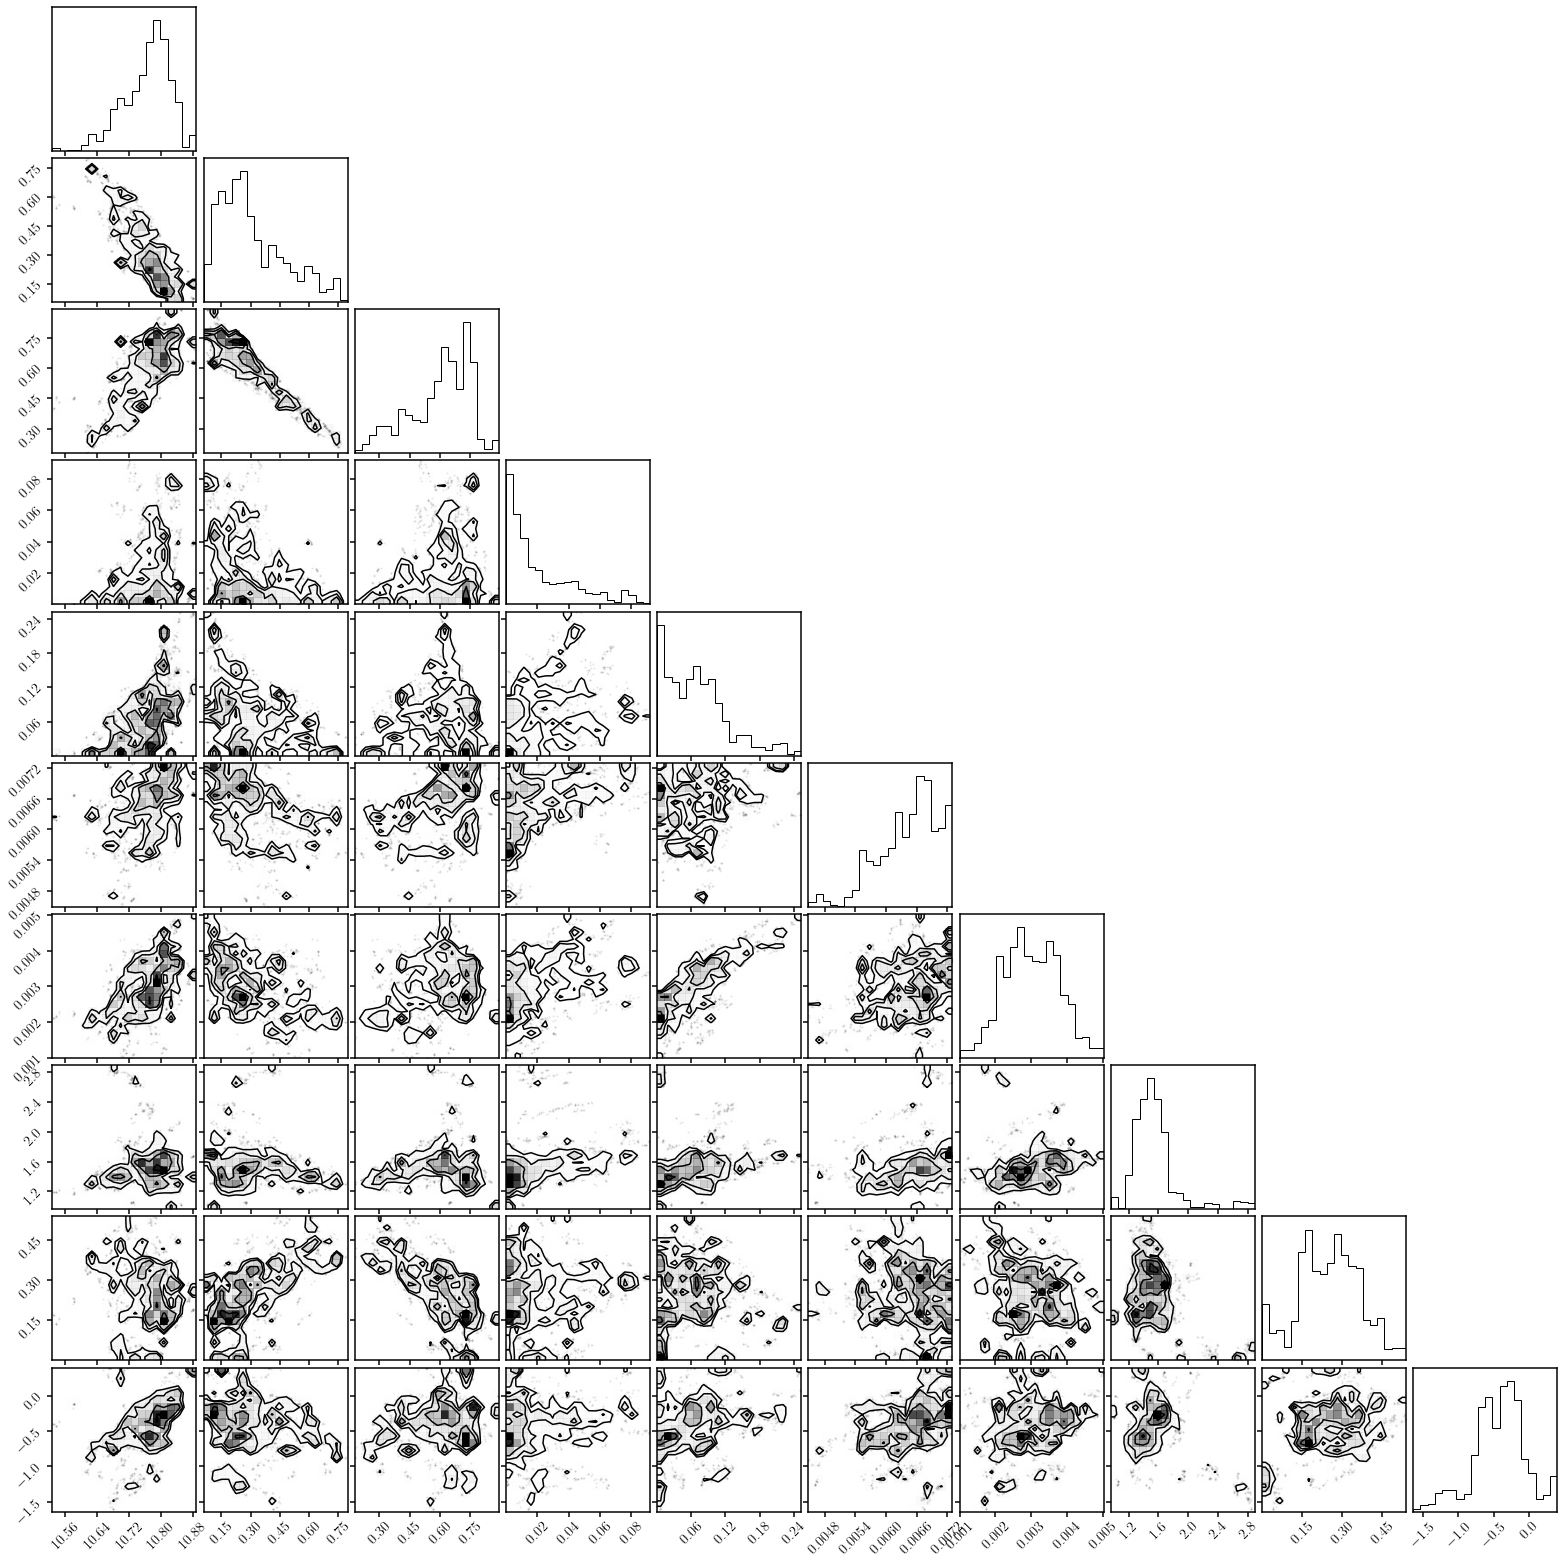

In [14]:
flat_chain = desi_mcmc._flatten_chain(zeus_chain['mcmc_chain'])
_ = DFM.corner(flat_chain, truths=[prop['logM_fiber'][igal], None, None, None, None, None, None, None, None, None])

In [15]:
priors = Infer.load_priors([
        Infer.UniformPrior(8, 12, label='sed'),
        Infer.FlatDirichletPrior(4, label='sed'), 
        Infer.UniformPrior(np.array([6.9e-5, 6.9e-5, 0., 0., -2.2]), np.array([7.3e-3, 7.3e-3, 3., 4., 0.4]), label='sed'), 
        Infer.UniformPrior(np.array([0.8, 0.8, 0.8]), np.array([1., 1., 1.]), label='flux_calib')
])

desi_mcmc = Infer.desiMCMC(prior=priors, flux_calib=FluxCalib.constant_flux_DESI_arms)

t0 = time.time()
zeus_chain = desi_mcmc.run(
    wave_obs=[specs['wave_b'], specs['wave_r'], specs['wave_z']],
    flux_obs=[specs['flux_b'][igal], specs['flux_r'][igal], specs['flux_z'][igal]], 
    flux_ivar_obs=[specs['ivar_b'][igal], specs['ivar_r'][igal], specs['ivar_z'][igal]], 
    zred=z, 
    sampler='zeus',
    nwalkers=30, 
    burnin=100,
    opt_maxiter=2000,
    niter=100, 
    debug=True)
print('%f sec' % (time.time() - t0))

--- initializing the walkers ---


Initialising ensemble of 30 walkers...
Sampling progress :   0%|          | 0/100 [00:00<?, ?it/s]

initial theta = [10.379765711477773, 0.6260448044399594, 0.3650784074754544, 0.698939557110399, 0.999999970970832, 0.004342316007444299, 0.003529036714115175, 1.3595938126257905, 0.3902006953667938, -0.7951116210380038, 0.8705458451772474, 0.859187194042956, 0.851255672379442]
--- burn-in ---


Sampling progress : 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]
Initialising ensemble of 30 walkers...
Sampling progress :   0%|          | 0/100 [00:00<?, ?it/s]

--- running main MCMC ---


Sampling progress : 100%|██████████| 100/100 [00:25<00:00,  3.88it/s]

Speculator.sed: redshift = 0.309752
Speculator.sed: tage = 10.179947
Speculator.sed: theta [ 1.03514342e+01  6.16956351e-01  2.57811153e-01  1.15096936e-01
  1.01355587e-02  4.57901498e-03  9.88711717e-04  1.39866113e+00
  4.50718552e-01 -5.87527327e-01  1.01799468e+01]
Speculator.sed: log(ssp lum) [-10.60405219 -10.60338102 -10.67248108 ...  -9.63770772  -9.64730841
  -9.65006295]
58.485810 sec


In [16]:
priors = Infer.load_priors([
        Infer.UniformPrior(8, 12, label='sed'),
        Infer.FlatDirichletPrior(4, label='sed'), 
        Infer.UniformPrior(np.array([6.9e-5, 6.9e-5, 0., 0., -2.2]), np.array([7.3e-3, 7.3e-3, 3., 4., 0.4]), label='sed'), 
        Infer.UniformPrior(0.9, 1., label='flux_calib')
    ])

desi_mcmc = Infer.desiMCMC(prior=priors, flux_calib=FluxCalib.constant_flux_factor)

t0 = time.time()
zeus_chain = desi_mcmc.run(
    wave_obs=specs['wave'], 
    flux_obs=specs['flux'][igal], 
    flux_ivar_obs=specs['ivar'][igal],
    photo_obs=photo['flux'][igal,:3], 
    photo_ivar_obs=photo['ivar'][igal,:3],
    zred=z, 
    bands='desi',
    sampler='zeus',
    nwalkers=30, 
    burnin=100,
    opt_maxiter=2000,
    niter=100, 
    debug=True)
print('%f sec' % (time.time() - t0))

/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]
/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1520: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  integrand = integrand[values_slice]


--- initializing the walkers ---


Initialising ensemble of 30 walkers...
Sampling progress :   0%|          | 0/100 [00:00<?, ?it/s]

initial theta = [10.243904053446027, 0.4733351016478067, 0.6371081610587748, 0.8017339016239362, 0.7574892806554638, 0.007299999963978618, 0.0005231371785721832, 0.969985150293128, 0.3364779471161579, -1.2469679780864178, 0.9000053819661351]
--- burn-in ---


Sampling progress : 100%|██████████| 100/100 [01:14<00:00,  1.34it/s]
Initialising ensemble of 30 walkers...
Sampling progress :   0%|          | 0/100 [00:00<?, ?it/s]

--- running main MCMC ---


Sampling progress : 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]

Speculator.sed: redshift = 0.309752
Speculator.sed: tage = 10.179947
Speculator.sed: theta [ 1.03657987e+01  4.17949787e-01  4.87515663e-01  8.50520355e-02
  9.48251496e-03  6.36069272e-03  4.62916334e-03  1.44332578e+00
  5.88608239e-01 -5.88147926e-02  1.01799468e+01]
Speculator.sed: log(ssp lum) [-10.63958334 -10.65391806 -10.73245344 ...  -9.97611875  -9.98846176
  -9.99292566]
153.200630 sec


# postprocessing the chains

In [17]:
flat_chain = desi_mcmc._flatten_chain(zeus_chain['mcmc_chain'])
sfr_100myr = desi_mcmc.model.avgSFR(flat_chain, z, dt=0.1)
sfr_1gyr = desi_mcmc.model.avgSFR(flat_chain, z, dt=1.)

In [18]:
z_mw = desi_mcmc.model.Z_MW(flat_chain, z)